In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon
from sklearn.cluster import KMeans
from scipy.stats import f_oneway
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Ellipse

df_integrated = pd.read_csv("run1/all3df_integrated.csv")
print(" File read done")

 File read done


Explained variance by PCs: [0.21045685 0.13851577 0.11998582 0.08746482 0.07890208]


C:\Miniforge-all\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


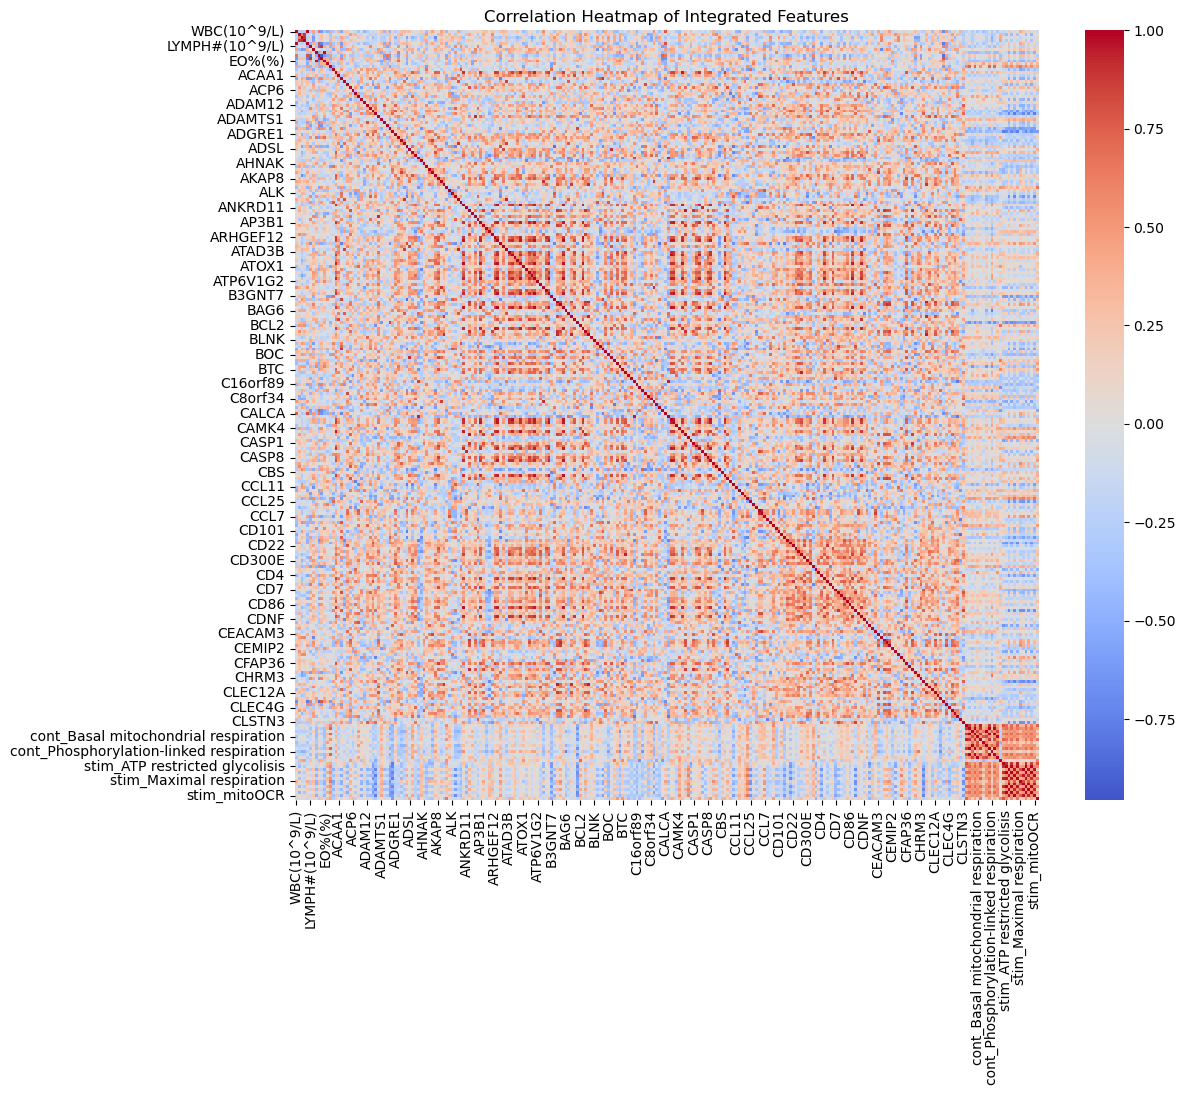

  PatientID  Timepoint  WBC(10^9/L)  RBC(10^12/L)  HGB(g/L)  HCT(L/L)  \
0  RB01_005          0    -0.566088      0.245255  0.457518  0.277068   
1  RB01_005          1    -0.029315     -0.822380 -0.465658 -0.780828   
2  RB01_005          2    -0.108163     -0.303391 -0.106646 -0.128459   
3  RB01_006          0    -0.126359     -0.318219 -0.209221 -0.375301   
4  RB01_006          1     0.916860      0.274911  0.457518  0.259436   

   NEUT#(10^9/L)  LYMPH#(10^9/L)  MONO#(10^9/L)  EO#(10^9/L)  ...  \
0      -0.690330        0.652180       0.188454    -0.463581  ...   
1       0.291344       -1.301912      -0.150763    -0.902292  ...   
2      -0.311643       -0.132028       1.658397     3.046107  ...   
3      -0.104821       -0.029181      -0.716126     0.476514  ...   
4       1.139022       -0.916236      -1.168416     0.225822  ...   

   stim_Phosphorylation-linked respiration  \
0                                -0.202407   
1                                 1.704360   
2       

In [2]:
#  it should run seperately , dnt run after anything
df_integrated = df_integrated.loc[:, ~df_integrated.columns.str.contains('^Unnamed')]
df_integrated = df_integrated.reset_index(drop=True)
# 1️⃣ Prepare numeric matrix
numeric_cols = [col for col in df_integrated.columns if col not in ['PatientID','Timepoint']]
X = df_integrated[numeric_cols].values

# 2️⃣ Optional: Standardize again (late integration scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3️⃣ PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Add PCA results back to dataframe
for i in range(X_pca.shape[1]):
    df_integrated[f'PC{i+1}'] = X_pca[:,i]

print("Explained variance by PCs:", pca.explained_variance_ratio_)

# 4️⃣ K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_integrated['cluster'] = kmeans.fit_predict(X_scaled)

# 5️⃣ Correlation heatmap
corr_matrix = pd.DataFrame(X_scaled, columns=numeric_cols).corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Integrated Features')
plt.show()

# 6️⃣ Show final integrated dataframe head with cluster and PCA
print(df_integrated.head())


C:\Users\mondalsy\AppData\Local\Temp\ipykernel_24500\3832252806.py:31: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(1 - corr_df.abs(), method='average')



Feature clusters:
       Marker  Cluster
85   ATP6V1G2        1
219     CHRM1        2
15      ACAA1        3
98        BAX        4
37     ADGRG3        5
..        ...      ...
81    ATP6AP2      250
113      BRD2      251
177     CD244      252
230    CLEC4G      253
226    CLEC1A      254

[262 rows x 2 columns]


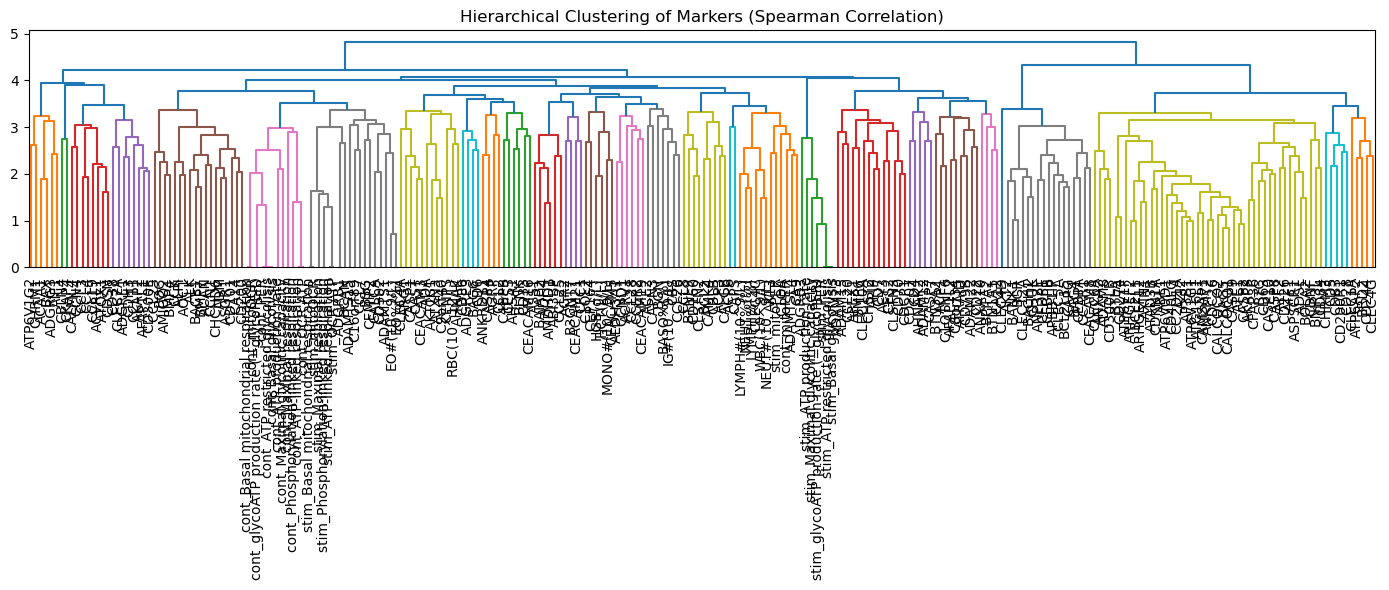

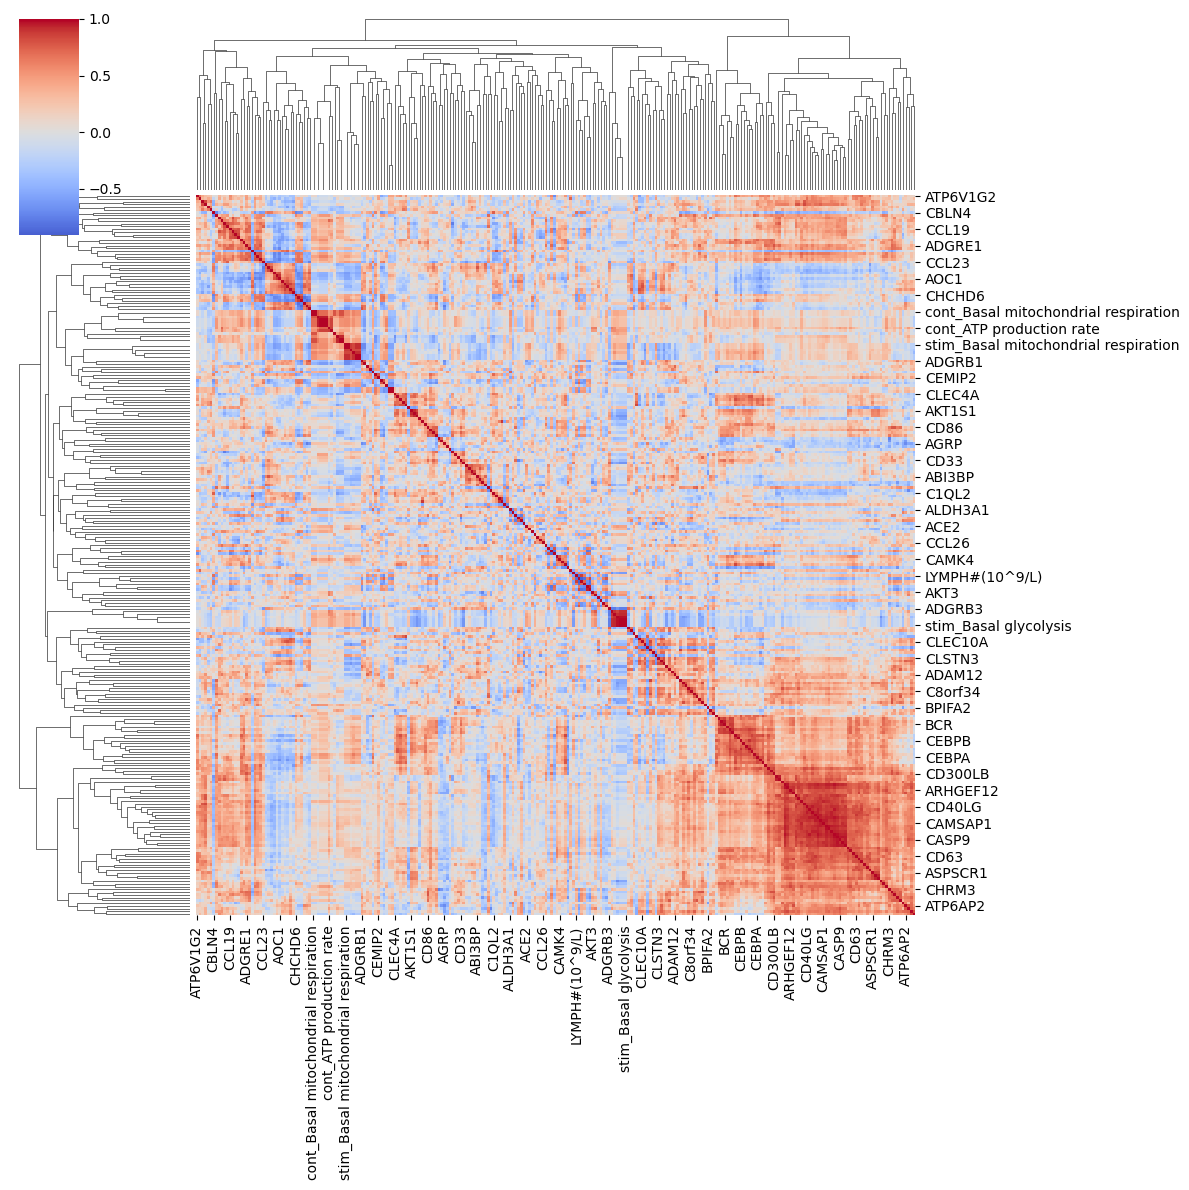


Strongly correlated markers (|r| ≥ 0.7):
                                   Marker_1      Marker_2  Spearman_r
34150                 stim_Basal glycolysis      stim_PER    1.000000
34161  stim_Basal mitochondrial respiration  stim_mitoOCR    1.000000
34131        stim_ATP restricted glycolisis      stim_PER    1.000000
33966  cont_Basal mitochondrial respiration  cont_mitoOCR    1.000000
34140           stim_ATP-linked respiration  stim_OCR ATP    1.000000
...                                     ...           ...         ...
2279                               NEUT%(%)        CLEC4C   -0.822497
16291                                 ASGR1          CA14   -0.845201
1297                         LYMPH#(10^9/L)      NEUT%(%)   -0.845638
30158                                 CD160        CLSTN2   -0.855521
2060                               NEUT%(%)     LYMPH%(%)   -0.910687

[907 rows x 3 columns]


In [3]:
# ================================
# Hierarchical clustering & marker correlation
# ================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import spearmanr

# --------------------------------
# 1️⃣ Prepare numeric matrix again (standalone)
# --------------------------------
numeric_cols = [col for col in df_integrated.columns 
                if col not in ['PatientID', 'Timepoint', 'cluster'] 
                and not col.startswith('PC')]

X = df_integrated[numeric_cols]

# --------------------------------
# 2️⃣ Correlation matrix (Spearman – better for biomarkers)
# --------------------------------
corr_matrix, pvals = spearmanr(X)
corr_df = pd.DataFrame(corr_matrix, index=numeric_cols, columns=numeric_cols)

# --------------------------------
# 3️⃣ Hierarchical clustering on features
# --------------------------------
linkage_matrix = linkage(1 - corr_df.abs(), method='average')

# --------------------------------
# 4️⃣ Cluster features (markers)
# --------------------------------
feature_clusters = fcluster(linkage_matrix, t=0.3, criterion='distance')

feature_cluster_df = pd.DataFrame({
    'Marker': numeric_cols,
    'Cluster': feature_clusters
}).sort_values('Cluster')

print("\nFeature clusters:")
print(feature_cluster_df)

# --------------------------------
# 5️⃣ Dendrogram
# --------------------------------
plt.figure(figsize=(14, 6))
dendrogram(
    linkage_matrix,
    labels=numeric_cols,
    leaf_rotation=90,
    leaf_font_size=10
)
plt.title('Hierarchical Clustering of Markers (Spearman Correlation)')
plt.tight_layout()
plt.show()

# --------------------------------
# 6️⃣ Correlation heatmap WITH hierarchical ordering
# --------------------------------
sns.clustermap(
    corr_df,
    row_linkage=linkage_matrix,
    col_linkage=linkage_matrix,
    cmap='coolwarm',
    center=0,
    figsize=(12, 12)
)
plt.show()

# --------------------------------
# 7️⃣ Identify strongly correlated marker pairs
# --------------------------------
corr_threshold = 0.7

strong_corr = (
    corr_df
    .where(np.triu(np.ones(corr_df.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)

strong_corr.columns = ['Marker_1', 'Marker_2', 'Spearman_r']

strong_corr = strong_corr.loc[strong_corr['Spearman_r'].abs() >= corr_threshold]

print("\nStrongly correlated markers (|r| ≥ 0.7):")
print(strong_corr.sort_values(by='Spearman_r', ascending=False))


Number of significant features: 50
Significant features: ['NEUT#(10^9/L)', 'LYMPH#(10^9/L)', 'EO#(10^9/L)', 'NEUT%(%)', 'LYMPH%(%)', 'EO%(%)', 'ABI3BP', 'ACAN', 'ADAM12', 'ADAM23', 'ADAMTS15', 'ADGRB1', 'ADGRE3', 'ADM', 'AGRP', 'AMIGO2', 'ASGR1', 'ATP6AP2', 'BGN', 'BMP7', 'C16orf89', 'CA14', 'CALCA', 'CCL2', 'CCL23', 'CCL25', 'CCL7', 'CCN4', 'CD101', 'CD200', 'CD207', 'CD244', 'CD300LB', 'CD302', 'CD4', 'CD6', 'CD70', 'CDCP1', 'CEMIP2', 'CHCHD6', 'CHST2', 'CLEC10A', 'CLEC4C', 'CLSTN3', 'stim_ATP-linked respiration', 'stim_Basal mitochondrial respiration', 'stim_Maximal respiration', 'stim_OCR ATP', 'stim_Phosphorylation-linked respiration', 'stim_mitoOCR']


<Figure size 1200x800 with 0 Axes>

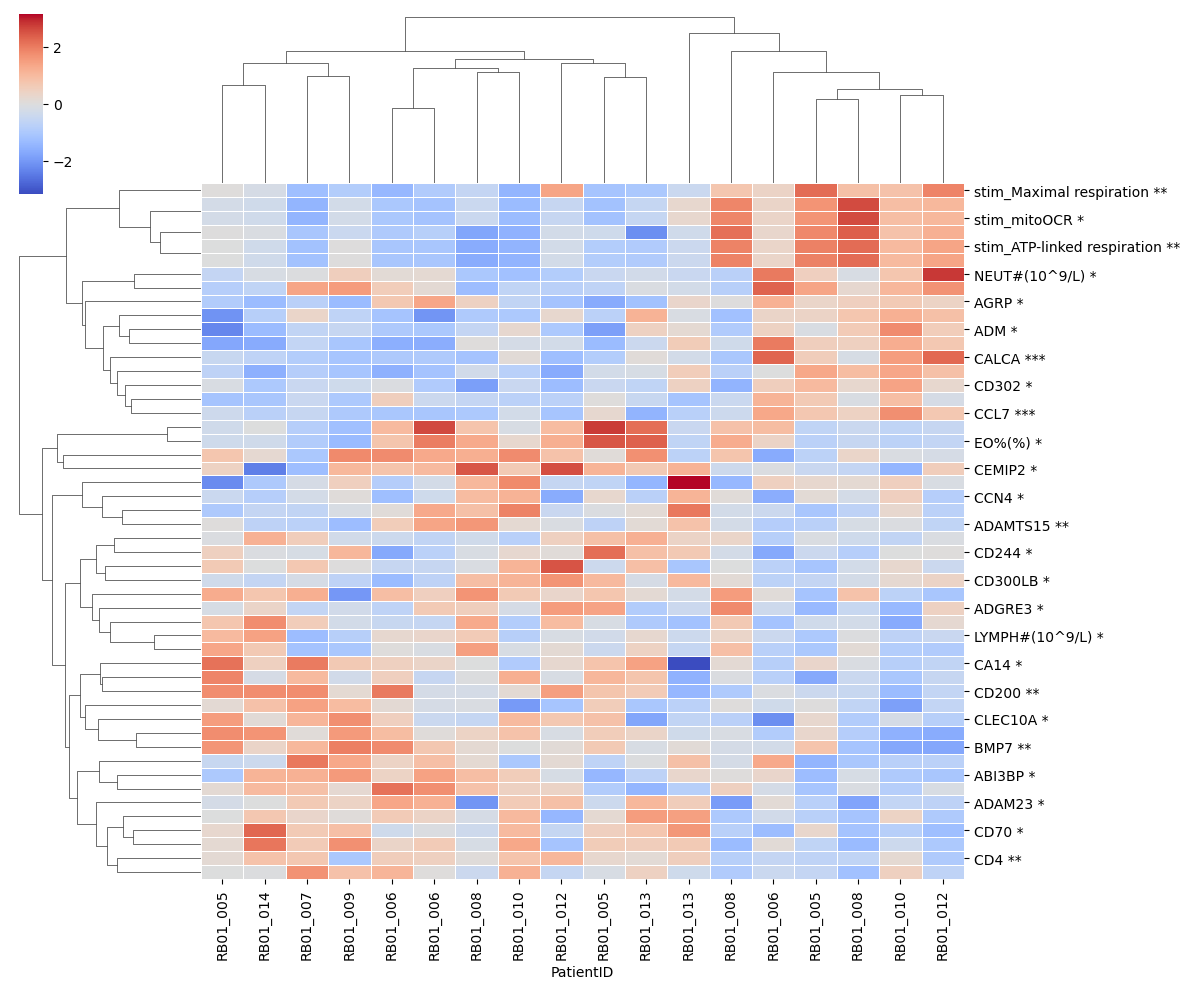

In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# ---------------------------
# 1️⃣ Clean dataframe
# ---------------------------
# Drop unnamed index columns
df_integrated = df_integrated.loc[:, ~df_integrated.columns.str.contains('^Unnamed')]
df_integrated = df_integrated.reset_index(drop=True)

# Identify numeric columns
numeric_cols = [col for col in df_integrated.columns if col not in ['PatientID','Timepoint']]

# ---------------------------
# 2️⃣ Compute ANOVA p-values
# ---------------------------
p_values = {}
timepoints = df_integrated['Timepoint'].unique()
for col in numeric_cols:
    groups = [df_integrated[df_integrated['Timepoint']==tp][col].values for tp in timepoints]
    f_stat, p_val = f_oneway(*groups)
    p_values[col] = p_val

p_values = pd.Series(p_values)

# Function to convert p-value to stars
def significance_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

sig_stars = p_values.apply(significance_stars)

# ---------------------------
# 3️⃣ Select significant features
# ---------------------------
sig_features = p_values[p_values < 0.05].index.tolist()
print(f"Number of significant features: {len(sig_features)}")
print("Significant features:", sig_features)

# ---------------------------
# 4️⃣ Create subset with significant features
# ---------------------------
sig_data = df_integrated[['PatientID'] + sig_features]

# Add significance stars to feature names
sig_labels = [f"{f} {sig_stars[f]}" for f in sig_features]

# Create features x samples matrix
combined_data_scaled = sig_data[sig_features].T  # features x samples
combined_data_scaled.columns = sig_data['PatientID']  # samples as columns
combined_data_scaled.index = sig_labels

# Optional: scale features for better heatmap visualization
scaler = StandardScaler()
combined_data_scaled.loc[:, :] = scaler.fit_transform(combined_data_scaled)

# ---------------------------
# 5️⃣ Plot clustered heatmap
# ---------------------------
plt.figure(figsize=(12, 8))
clustermap = sns.clustermap(
    combined_data_scaled,
    cmap='coolwarm',
    figsize=(12, 10),
    row_cluster=True,
    col_cluster=True,
    linewidths=0.5,
    cbar_pos=(0.02, 0.8, 0.02, 0.18)
)

plt.show()


<Figure size 1200x800 with 0 Axes>

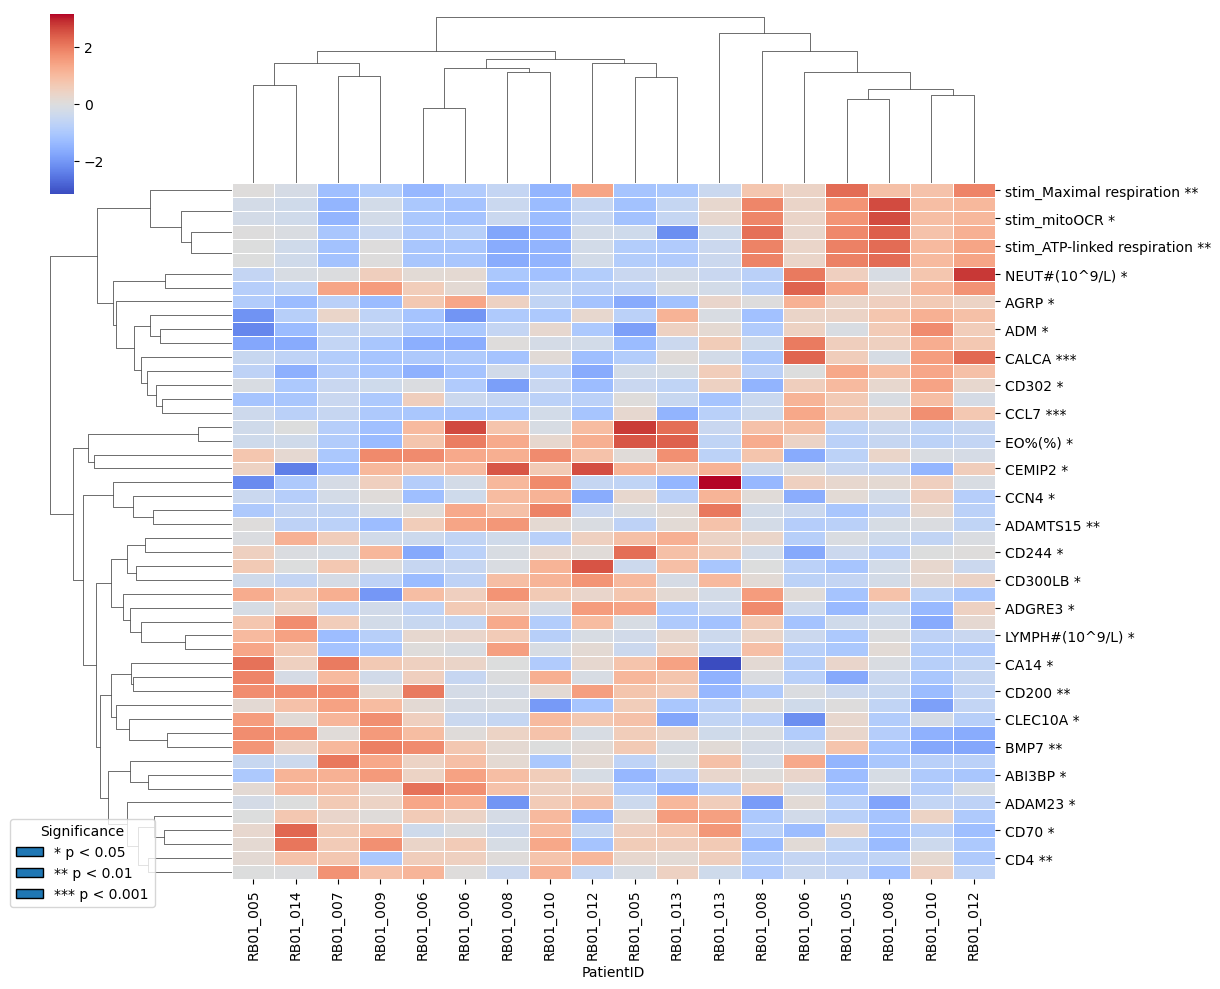

In [10]:
import matplotlib.patches as mpatches

# ---------------------------
# 5️⃣ Plot clustered heatmap
# ---------------------------
plt.figure(figsize=(12, 8))
clustermap = sns.clustermap(
    combined_data_scaled,
    cmap='coolwarm',
    figsize=(12, 10),
    row_cluster=True,
    col_cluster=True,
    linewidths=0.5,
    cbar_pos=(0.02, 0.8, 0.02, 0.18)
)

# Create legend for significance stars
legend_elements = [
    mpatches.Patch(edgecolor='black', label='* p < 0.05'),
    mpatches.Patch(edgecolor='black', label='** p < 0.01'),
    mpatches.Patch(edgecolor='black', label='*** p < 0.001')
]

# Add legend on left-bottom side
clustermap.ax_heatmap.legend(
    handles=legend_elements,
    title='Significance',
    loc='lower left',           # left-bottom
    bbox_to_anchor=(-0.3, -0.05)  # slightly outside the heatmap
)

plt.show()


In [11]:
# Assuming p_values is a pandas Series with feature names as index
sig_001 = p_values[p_values < 0.001].index.tolist()
sig_01  = p_values[(p_values >= 0.001) & (p_values < 0.01)].index.tolist()
sig_05  = p_values[(p_values >= 0.01) & (p_values < 0.05)].index.tolist()

# Number of features in each category
print("Number of features with p < 0.001 (***):", len(sig_001))
print("Features:", sig_001, "\n")

print("Number of features with 0.001 <= p < 0.01 (**):", len(sig_01))
print("Features:", sig_01, "\n")

print("Number of features with 0.01 <= p < 0.05 (*):", len(sig_05))
print("Features:", sig_05)


Number of features with p < 0.001 (***): 5
Features: ['ACAN', 'ADAM12', 'CALCA', 'CCL23', 'CCL7'] 

Number of features with 0.001 <= p < 0.01 (**): 10
Features: ['NEUT%(%)', 'ADAMTS15', 'ADGRB1', 'ASGR1', 'BMP7', 'CD200', 'CD4', 'stim_ATP-linked respiration', 'stim_Maximal respiration', 'stim_OCR ATP'] 

Number of features with 0.01 <= p < 0.05 (*): 35
Features: ['NEUT#(10^9/L)', 'LYMPH#(10^9/L)', 'EO#(10^9/L)', 'LYMPH%(%)', 'EO%(%)', 'ABI3BP', 'ADAM23', 'ADGRE3', 'ADM', 'AGRP', 'AMIGO2', 'ATP6AP2', 'BGN', 'C16orf89', 'CA14', 'CCL2', 'CCL25', 'CCN4', 'CD101', 'CD207', 'CD244', 'CD300LB', 'CD302', 'CD6', 'CD70', 'CDCP1', 'CEMIP2', 'CHCHD6', 'CHST2', 'CLEC10A', 'CLEC4C', 'CLSTN3', 'stim_Basal mitochondrial respiration', 'stim_Phosphorylation-linked respiration', 'stim_mitoOCR']


In [ ]:
#Clustering: see if samples naturally separate based on proteomics/blood markers.
K-means, hierarchical clustering.
Heatmaps with significant features.

Significant features: ['NEUT#(10^9/L)', 'LYMPH#(10^9/L)', 'EO#(10^9/L)', 'NEUT%(%)', 'LYMPH%(%)', 'EO%(%)', 'ABI3BP', 'ACAN', 'ADAM12', 'ADAM23', 'ADAMTS15', 'ADGRB1', 'ADGRE3', 'ADM', 'AGRP', 'AMIGO2', 'ASGR1', 'ATP6AP2', 'BGN', 'BMP7', 'C16orf89', 'CA14', 'CALCA', 'CCL2', 'CCL23', 'CCL25', 'CCL7', 'CCN4', 'CD101', 'CD200', 'CD207', 'CD244', 'CD300LB', 'CD302', 'CD4', 'CD6', 'CD70', 'CDCP1', 'CEMIP2', 'CHCHD6', 'CHST2', 'CLEC10A', 'CLEC4C', 'CLSTN3', 'stim_ATP-linked respiration', 'stim_Basal mitochondrial respiration', 'stim_Maximal respiration', 'stim_OCR ATP', 'stim_Phosphorylation-linked respiration', 'stim_mitoOCR']


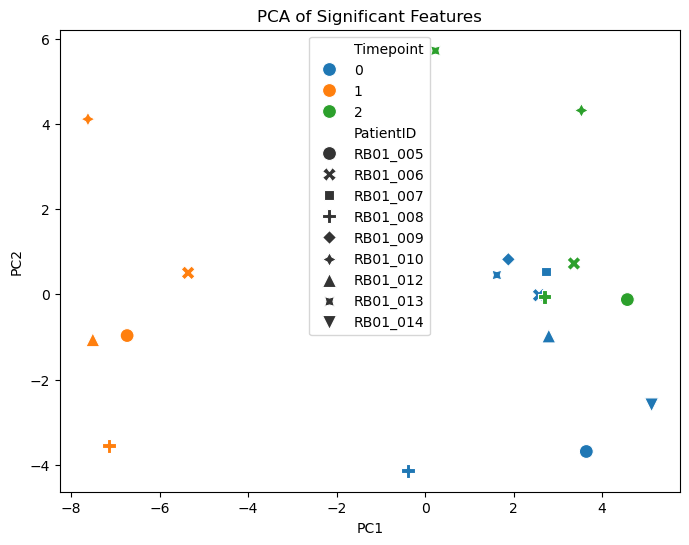

C:\Miniforge-all\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


K-means cluster assignment per sample:
    PatientID  KMeans_cluster
0   RB01_005               0
1   RB01_005               2
2   RB01_005               0
3   RB01_006               0
4   RB01_006               2
5   RB01_006               0
6   RB01_007               0
7   RB01_008               2
8   RB01_008               2
9   RB01_008               0
10  RB01_009               0
11  RB01_010               1
12  RB01_010               0
13  RB01_012               0
14  RB01_012               2
15  RB01_013               0
16  RB01_013               0
17  RB01_014               0


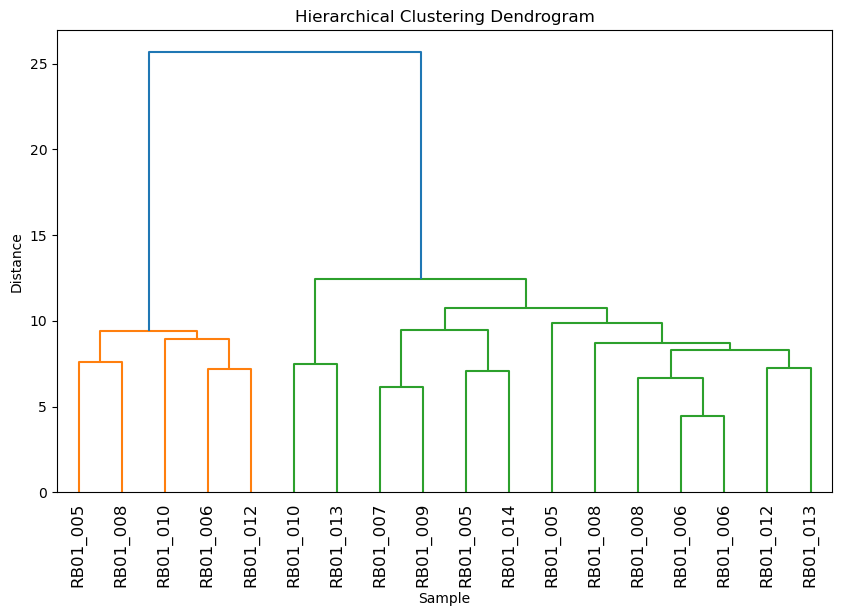

<Figure size 1200x800 with 0 Axes>

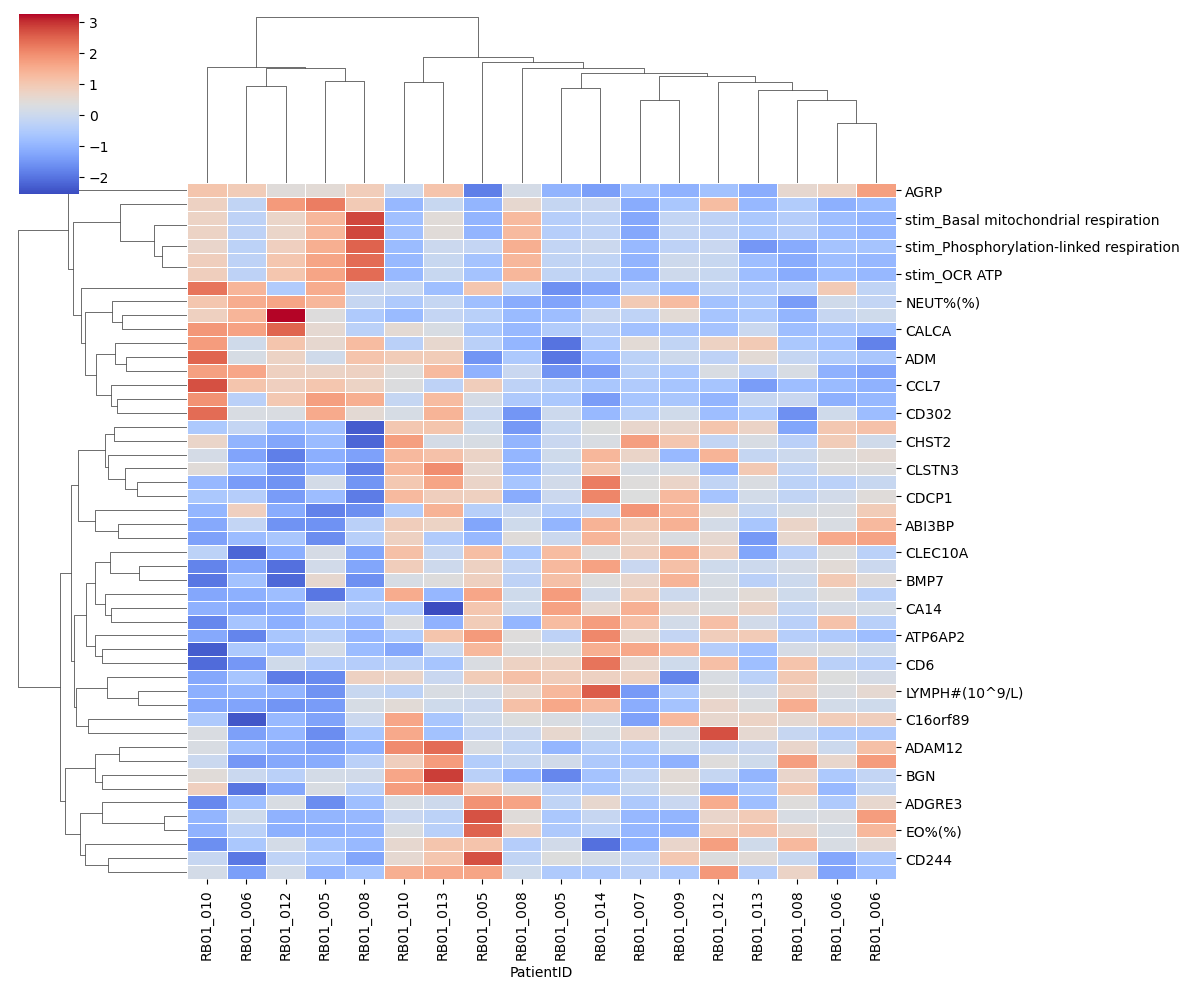

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

# ---------------------------
# 1️⃣ Prepare data
# ---------------------------
# Remove unwanted columns (if read from CSV)
df_integrated = df_integrated.loc[:, ~df_integrated.columns.str.contains('^Unnamed')]
df_integrated = df_integrated.reset_index(drop=True)

# Numeric features
numeric_cols = [col for col in df_integrated.columns if col not in ['PatientID','Timepoint']]

# ---------------------------
# 2️⃣ Compute p-values across timepoints (ANOVA)
# ---------------------------
p_values = {}
timepoints = df_integrated['Timepoint'].unique()
for col in numeric_cols:
    groups = [df_integrated[df_integrated['Timepoint']==tp][col].values for tp in timepoints]
    f_stat, p_val = f_oneway(*groups)
    p_values[col] = p_val

p_values = pd.Series(p_values)

# Select significant features (p < 0.05)
sig_features = p_values[p_values < 0.05].index.tolist()
print("Significant features:", sig_features)

# Subset data for clustering
data_cluster = df_integrated[sig_features].copy()

# Scale features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cluster)
data_scaled = pd.DataFrame(data_scaled, columns=sig_features, index=df_integrated['PatientID'])

# ---------------------------
# 3️⃣ PCA (optional, for visualization)
# ---------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data_scaled)
df_pca = pd.DataFrame(X_pca, columns=['PC1','PC2'])
df_pca['PatientID'] = df_integrated['PatientID'].values
df_pca['Timepoint'] = df_integrated['Timepoint'].values

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='PC1',
    y='PC2',
    data=df_pca,
    hue='Timepoint',          # color by timepoint
    style='PatientID',        # optional: different shape per patient
    s=100,
    palette='tab10'
)
plt.title("PCA of Significant Features")
plt.show()


# ---------------------------
# 4️⃣ K-means clustering
# ---------------------------
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data_scaled)
df_integrated['KMeans_cluster'] = clusters
print("K-means cluster assignment per sample:\n", df_integrated[['PatientID','KMeans_cluster']])

# ---------------------------
# 5️⃣ Hierarchical clustering (dendrogram)
# ---------------------------
linked = linkage(data_scaled, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linked, labels=df_integrated['PatientID'].values, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample")
plt.ylabel("Distance")
plt.show()

# ---------------------------
# 6️⃣ Heatmap with significant features
# ---------------------------
plt.figure(figsize=(12,8))
sns.clustermap(
    data_scaled.T,  # features as rows, samples as columns
    cmap='coolwarm',
    row_cluster=True,
    col_cluster=True,
    linewidths=0.5,
    figsize=(12,10)
)
plt.show()
